In [3]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

!pip install yfinance
import yfinance as yf

In [4]:
sentiment = pd.read_csv('sentiment_hourly.csv')
sentiment = sentiment.groupby(np.arange(len(sentiment))//24).mean()
sentiment.head

<bound method NDFrame.head of      Sent_Negatives  Sent_Positives   Overall
0         -0.391724        0.443921  0.052197
1         -0.296391        0.339874  0.043483
2         -0.381668        0.445965  0.064297
3         -0.399142        0.450266  0.051124
4         -0.398013        0.420093  0.022080
..              ...             ...       ...
534       -0.411888        0.507678  0.095789
535       -0.411246        0.506598  0.095351
536       -0.396557        0.507405  0.110848
537       -0.427059        0.502655  0.075596
538       -0.423759        0.494819  0.071059

[539 rows x 3 columns]>

In [5]:
df = yf.download(tickers="BTC-USD",
                start="2017-08-01",
                end="2019-01-21",
                interval="1d")
df = df.reset_index()
sentiment = pd.concat([df[['Open', 'Close', 'Adj Close']], sentiment[['Overall']]], axis=1)

num_features = 4
num_train = 470
num_test = 69

training_set = sentiment.iloc[:num_train].values
test_set = sentiment.iloc[num_train:].values

sentiment.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of             Open        Close    Adj Close   Overall
0    2871.300049  2718.260010  2718.260010  0.052197
1    2727.129883  2710.669922  2710.669922  0.043483
2    2709.560059  2804.729980  2804.729980  0.064297
3    2806.929932  2895.889893  2895.889893  0.051124
4    2897.629883  3252.909912  3252.909912  0.022080
..           ...          ...          ...       ...
534  3651.871094  3678.563965  3678.563965  0.095789
535  3677.990479  3657.839355  3657.839355  0.095351
536  3652.377930  3728.568359  3728.568359  0.110848
537  3725.446045  3601.013672  3601.013672  0.075596
538  3600.372803  3576.032471  3576.032471  0.071059

[539 rows x 4 columns]>

In [6]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, num_train):
    X_train.append(training_set_scaled[i-60:i, 0:num_features])
    y_train.append(training_set_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

In [7]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, input_shape = (X_train.shape[1], num_features))))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# model.summary()

In [8]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 8)

Epoch 1/100
52/52 [==============================] - 9s 7ms/step - loss: 0.0679
Epoch 2/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0092
Epoch 3/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0052
Epoch 4/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 5/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 6/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 7/100
52/52 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 8/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0036
Epoch 9/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 10/100
52/52 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 11/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0043
Epoch 12/100
52/52 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 13/100
52/52 [=================

In [9]:
# Getting the predicted stock price
dataset_train = sentiment.iloc[:num_train]
dataset_test = sentiment.iloc[num_train:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,num_features)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, num_test+60):
    X_test.append(inputs[i-60:i, 0:num_features])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

In [10]:
predicted_stock_price = model.predict(X_test)
predicted_padded = np.zeros(shape=(len(predicted_stock_price), num_features))
predicted_padded[:,1] = predicted_stock_price[:,0]
predicted_padded = sc.inverse_transform(predicted_padded)

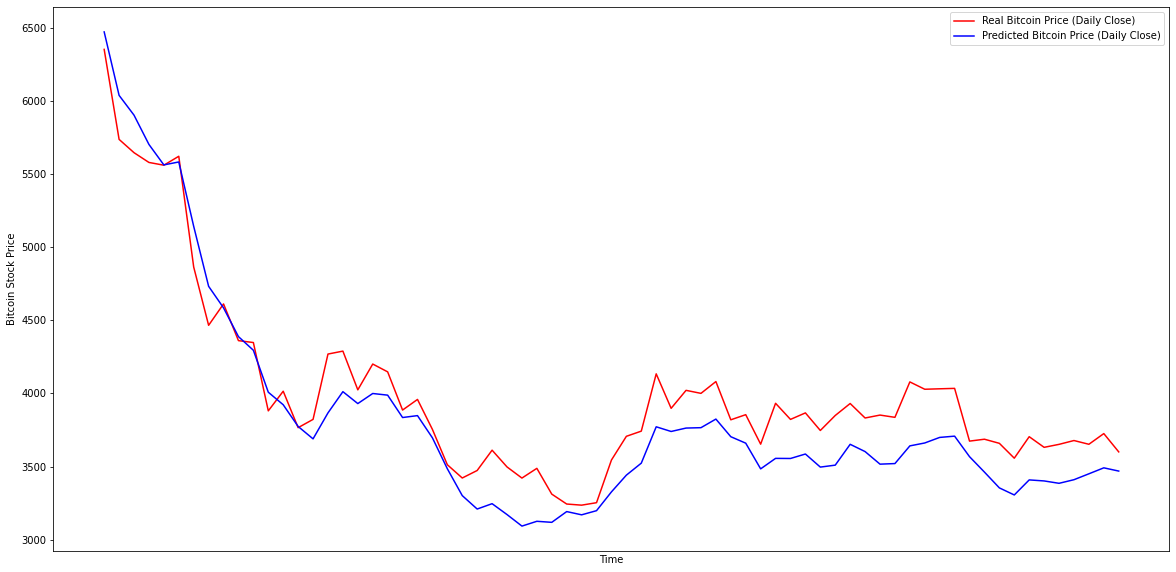

In [11]:
# Visualising the results
fig, ax1 = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), df.iloc[num_train:, 1:2], color='red', label = 'Real Bitcoin Price (Daily Close)')
ax1.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), predicted_padded[:,1], color = 'blue', label = 'Predicted Bitcoin Price (Daily Close)')

ax1.set_xlabel('Time')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax1.set_ylabel('Bitcoin Stock Price')
ax1.legend()

plt.show()

In [19]:
error_sum = 0

for i in range(len(predicted_padded)):
    diff = abs(predicted_padded[i,1] - df.loc[num_train+i, 'Close']) / df.loc[num_train+i, 'Close']
    error_sum += diff

error_avg = error_sum / len(predicted_padded)
acc = 1 - error_avg
print(acc)

0.9367660414579372


In [ ]:
# Sentiment plot
fig, ax1 = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)

ax1.plot(df.loc[num_train:, 'Date'].apply(lambda x: x.strftime('%Y-%m-%d')), sentiment.iloc[num_train:, 3:4], color='green', label = 'Daily Average Sentiment')

ax1.set_xlabel('Time')
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax1.set_ylabel('Sentiment Value')
ax1.legend()

plt.show()